# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides=2)
    
    return output_layer
    


### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    up_sample = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([up_sample, large_ip_layer])
    # TODO Add some number of separable convolution layers
    t_layer = separable_conv2d_batchnorm(concat_layer, filters, strides=1)
    output_layer = separable_conv2d_batchnorm(t_layer, filters, strides=1)
    
    return output_layer
    

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
   # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    layer1 = encoder_block(inputs, 64, 2)
    layer2 = encoder_block(layer1, 128, 2)    
        
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    layer3 = conv2d_batchnorm(layer2, 256, kernel_size=1, strides=1)
   
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer4 = decoder_block(layer3, layer1, 64)
    layer5 = decoder_block(layer4, inputs, 128)
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(layer5)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = .001
batch_size = 50
num_epochs = 75
steps_per_epoch = 50
validation_steps = 50
workers = 20

Epoch 1/75
49/50 [============================>.] - ETA: 1s - loss: 0.8066

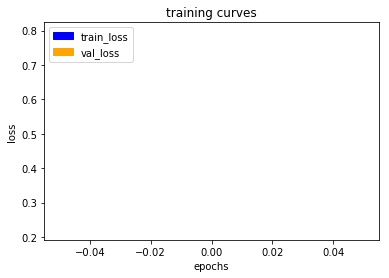

50/50 [==============================] - 117s - loss: 0.7952 - val_loss: 0.2203
Epoch 2/75
49/50 [============================>.] - ETA: 1s - loss: 0.0974

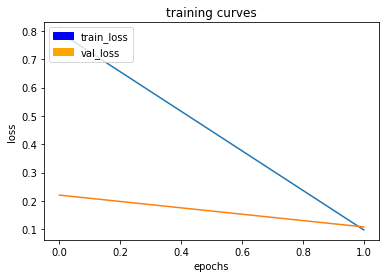

50/50 [==============================] - 110s - loss: 0.0975 - val_loss: 0.1079
Epoch 3/75
49/50 [============================>.] - ETA: 1s - loss: 0.0552

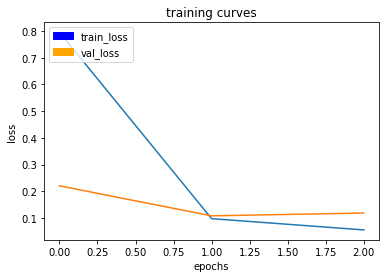

50/50 [==============================] - 110s - loss: 0.0552 - val_loss: 0.1185
Epoch 4/75
49/50 [============================>.] - ETA: 1s - loss: 0.0508

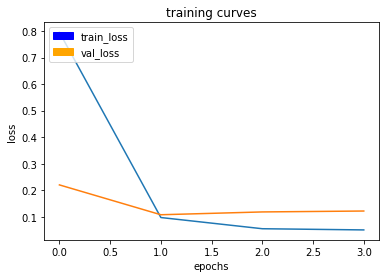

50/50 [==============================] - 110s - loss: 0.0509 - val_loss: 0.1219
Epoch 5/75
49/50 [============================>.] - ETA: 1s - loss: 0.0449

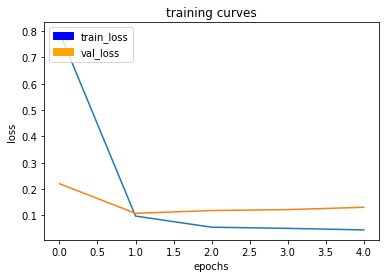

50/50 [==============================] - 111s - loss: 0.0449 - val_loss: 0.1308
Epoch 6/75
49/50 [============================>.] - ETA: 1s - loss: 0.0441

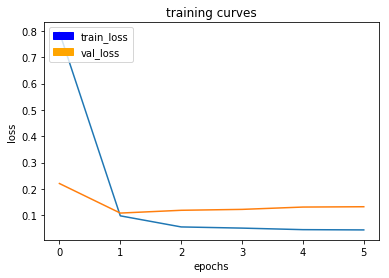

50/50 [==============================] - 110s - loss: 0.0439 - val_loss: 0.1320
Epoch 7/75
49/50 [============================>.] - ETA: 1s - loss: 0.0447

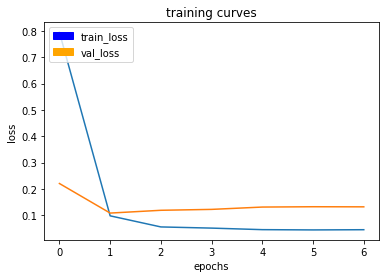

50/50 [==============================] - 110s - loss: 0.0446 - val_loss: 0.1316
Epoch 8/75
49/50 [============================>.] - ETA: 1s - loss: 0.0394

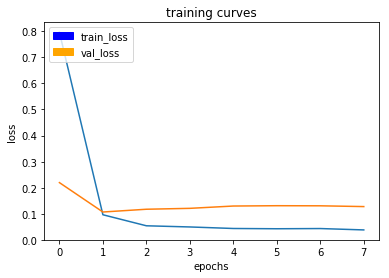

50/50 [==============================] - 110s - loss: 0.0394 - val_loss: 0.1286
Epoch 9/75
49/50 [============================>.] - ETA: 1s - loss: 0.0397

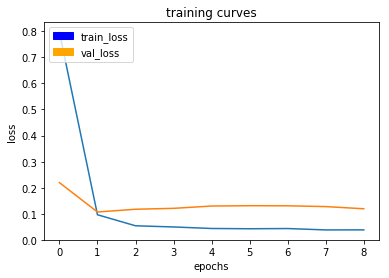

50/50 [==============================] - 111s - loss: 0.0396 - val_loss: 0.1203
Epoch 10/75
49/50 [============================>.] - ETA: 1s - loss: 0.0342

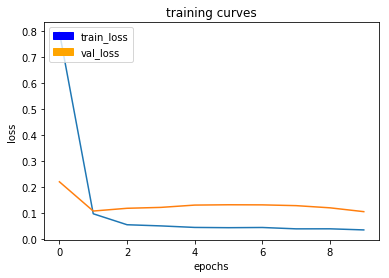

50/50 [==============================] - 110s - loss: 0.0353 - val_loss: 0.1055
Epoch 11/75
49/50 [============================>.] - ETA: 1s - loss: 0.0362

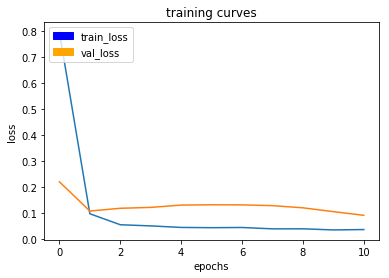

50/50 [==============================] - 111s - loss: 0.0367 - val_loss: 0.0915
Epoch 12/75
49/50 [============================>.] - ETA: 1s - loss: 0.0347

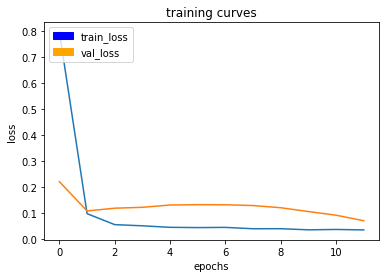

50/50 [==============================] - 110s - loss: 0.0349 - val_loss: 0.0703
Epoch 13/75
49/50 [============================>.] - ETA: 1s - loss: 0.0350

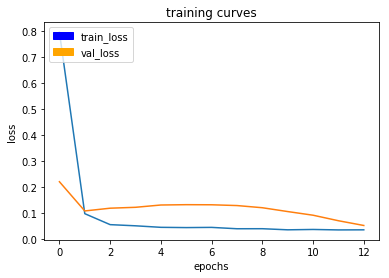

50/50 [==============================] - 111s - loss: 0.0353 - val_loss: 0.0520
Epoch 14/75
49/50 [============================>.] - ETA: 1s - loss: 0.0334

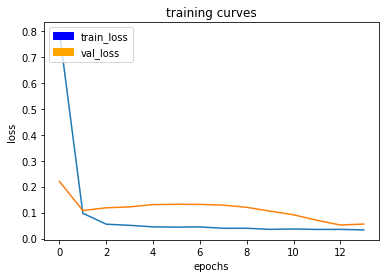

50/50 [==============================] - 110s - loss: 0.0332 - val_loss: 0.0558
Epoch 15/75
49/50 [============================>.] - ETA: 1s - loss: 0.0340

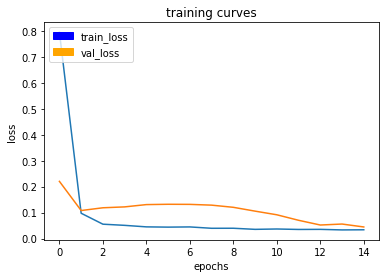

50/50 [==============================] - 110s - loss: 0.0339 - val_loss: 0.0445
Epoch 16/75
49/50 [============================>.] - ETA: 1s - loss: 0.0363

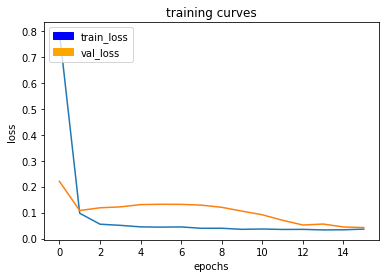

50/50 [==============================] - 113s - loss: 0.0363 - val_loss: 0.0423
Epoch 17/75
49/50 [============================>.] - ETA: 1s - loss: 0.0304

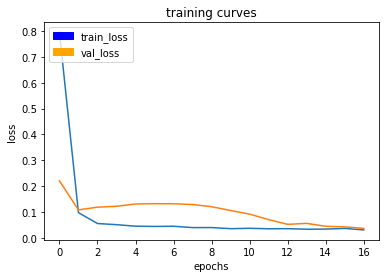

50/50 [==============================] - 110s - loss: 0.0304 - val_loss: 0.0365
Epoch 18/75
49/50 [============================>.] - ETA: 1s - loss: 0.0322

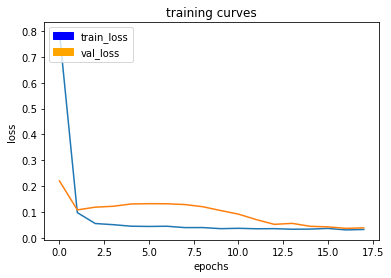

50/50 [==============================] - 110s - loss: 0.0321 - val_loss: 0.0385
Epoch 19/75
49/50 [============================>.] - ETA: 1s - loss: 0.0300

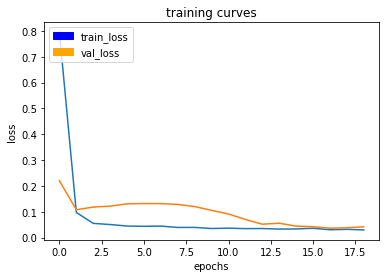

50/50 [==============================] - 111s - loss: 0.0299 - val_loss: 0.0418
Epoch 20/75
49/50 [============================>.] - ETA: 1s - loss: 0.0296

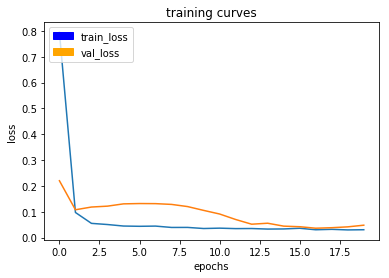

50/50 [==============================] - 110s - loss: 0.0306 - val_loss: 0.0482
Epoch 21/75
49/50 [============================>.] - ETA: 1s - loss: 0.0309

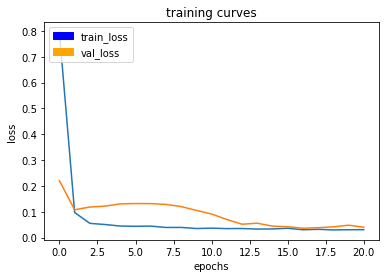

50/50 [==============================] - 110s - loss: 0.0308 - val_loss: 0.0403
Epoch 22/75
49/50 [============================>.] - ETA: 1s - loss: 0.0322

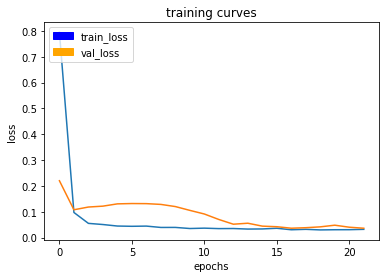

50/50 [==============================] - 110s - loss: 0.0321 - val_loss: 0.0364
Epoch 23/75
49/50 [============================>.] - ETA: 1s - loss: 0.0277

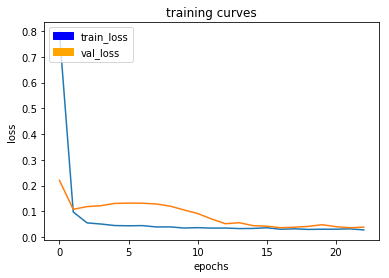

50/50 [==============================] - 110s - loss: 0.0279 - val_loss: 0.0386
Epoch 24/75
49/50 [============================>.] - ETA: 1s - loss: 0.0316

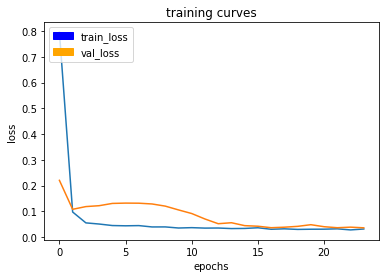

50/50 [==============================] - 110s - loss: 0.0315 - val_loss: 0.0361
Epoch 25/75
49/50 [============================>.] - ETA: 1s - loss: 0.0290

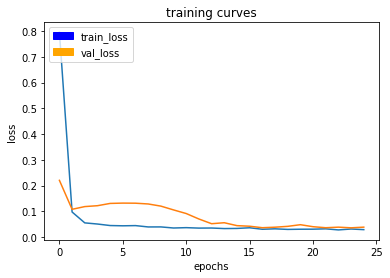

50/50 [==============================] - 107s - loss: 0.0289 - val_loss: 0.0386
Epoch 26/75
49/50 [============================>.] - ETA: 1s - loss: 0.0273

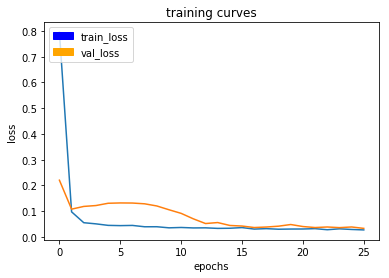

50/50 [==============================] - 110s - loss: 0.0272 - val_loss: 0.0332
Epoch 27/75
49/50 [============================>.] - ETA: 1s - loss: 0.0282

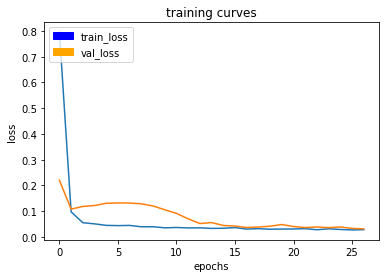

50/50 [==============================] - 110s - loss: 0.0281 - val_loss: 0.0312
Epoch 28/75
49/50 [============================>.] - ETA: 1s - loss: 0.0281

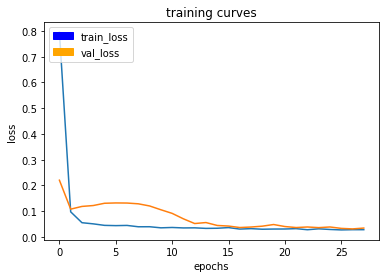

50/50 [==============================] - 110s - loss: 0.0280 - val_loss: 0.0344
Epoch 29/75
49/50 [============================>.] - ETA: 1s - loss: 0.0267

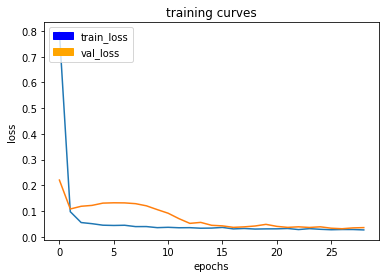

50/50 [==============================] - 110s - loss: 0.0266 - val_loss: 0.0355
Epoch 30/75
49/50 [============================>.] - ETA: 1s - loss: 0.0263

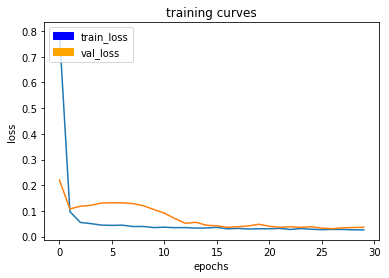

50/50 [==============================] - 110s - loss: 0.0263 - val_loss: 0.0367
Epoch 31/75
49/50 [============================>.] - ETA: 1s - loss: 0.0258

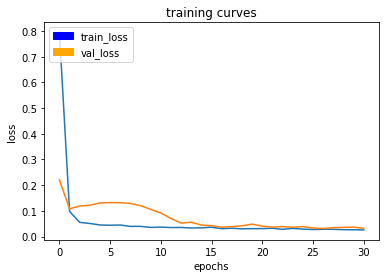

50/50 [==============================] - 110s - loss: 0.0257 - val_loss: 0.0319
Epoch 32/75
49/50 [============================>.] - ETA: 1s - loss: 0.0253

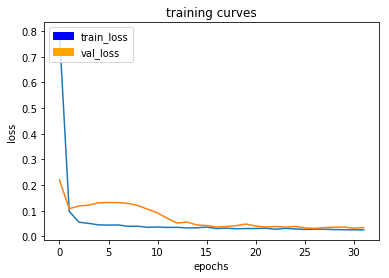

50/50 [==============================] - 110s - loss: 0.0253 - val_loss: 0.0343
Epoch 33/75
49/50 [============================>.] - ETA: 1s - loss: 0.0246

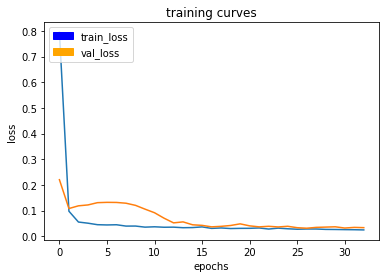

50/50 [==============================] - 110s - loss: 0.0245 - val_loss: 0.0333
Epoch 34/75
49/50 [============================>.] - ETA: 1s - loss: 0.0271

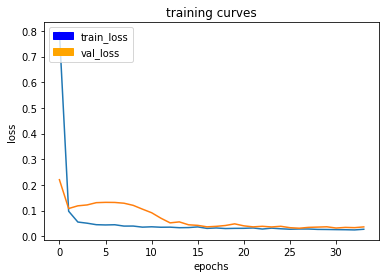

50/50 [==============================] - 110s - loss: 0.0270 - val_loss: 0.0363
Epoch 35/75
49/50 [============================>.] - ETA: 1s - loss: 0.0256

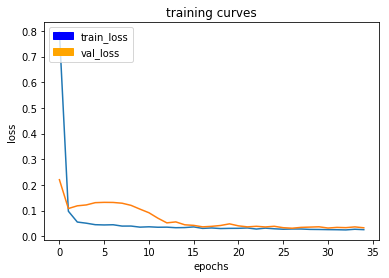

50/50 [==============================] - 110s - loss: 0.0254 - val_loss: 0.0328
Epoch 36/75
49/50 [============================>.] - ETA: 1s - loss: 0.0241

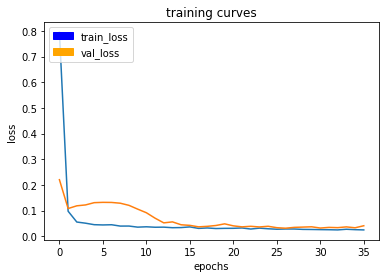

50/50 [==============================] - 110s - loss: 0.0245 - val_loss: 0.0408
Epoch 37/75
49/50 [============================>.] - ETA: 1s - loss: 0.0243

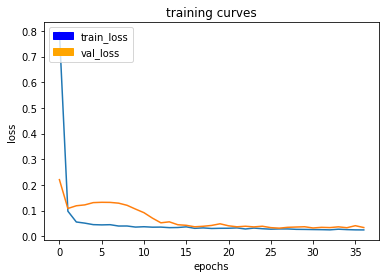

50/50 [==============================] - 110s - loss: 0.0243 - val_loss: 0.0336
Epoch 38/75
49/50 [============================>.] - ETA: 1s - loss: 0.0225

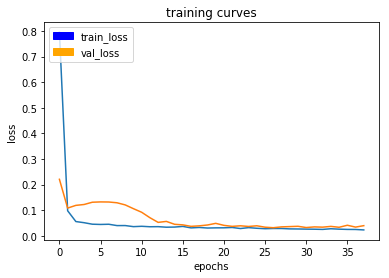

50/50 [==============================] - 111s - loss: 0.0225 - val_loss: 0.0392
Epoch 39/75
49/50 [============================>.] - ETA: 1s - loss: 0.0252

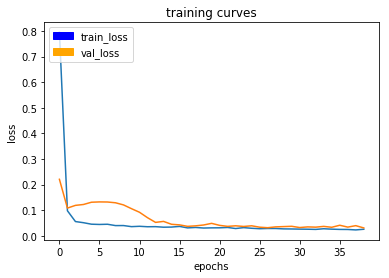

50/50 [==============================] - 110s - loss: 0.0253 - val_loss: 0.0303
Epoch 40/75
49/50 [============================>.] - ETA: 1s - loss: 0.0269

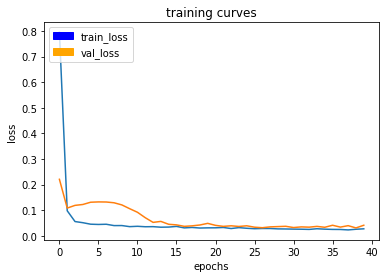

50/50 [==============================] - 110s - loss: 0.0269 - val_loss: 0.0408
Epoch 41/75
49/50 [============================>.] - ETA: 1s - loss: 0.0230

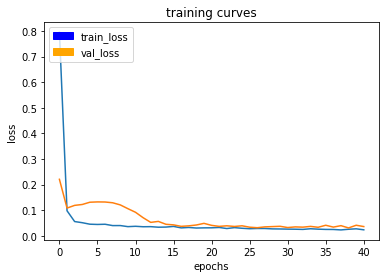

50/50 [==============================] - 110s - loss: 0.0229 - val_loss: 0.0356
Epoch 42/75
49/50 [============================>.] - ETA: 1s - loss: 0.0236

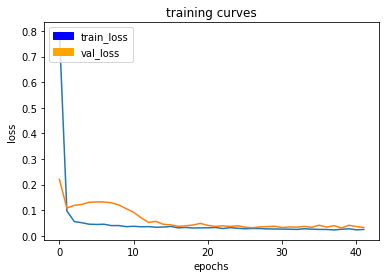

50/50 [==============================] - 110s - loss: 0.0242 - val_loss: 0.0320
Epoch 43/75
49/50 [============================>.] - ETA: 1s - loss: 0.0243

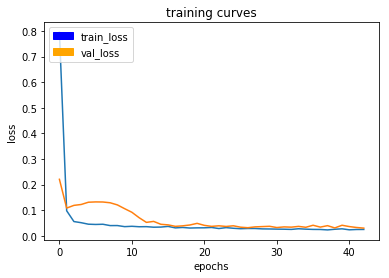

50/50 [==============================] - 110s - loss: 0.0243 - val_loss: 0.0295
Epoch 44/75
49/50 [============================>.] - ETA: 1s - loss: 0.0234

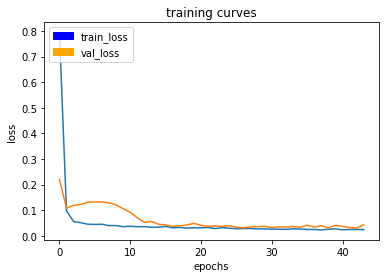

50/50 [==============================] - 110s - loss: 0.0234 - val_loss: 0.0432
Epoch 45/75
49/50 [============================>.] - ETA: 1s - loss: 0.0229

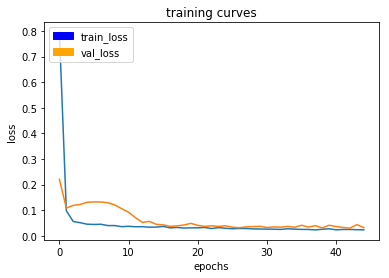

50/50 [==============================] - 109s - loss: 0.0228 - val_loss: 0.0314
Epoch 46/75
49/50 [============================>.] - ETA: 1s - loss: 0.0230

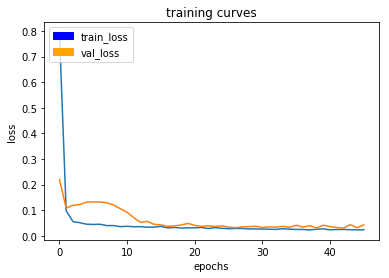

50/50 [==============================] - 110s - loss: 0.0230 - val_loss: 0.0422
Epoch 47/75
49/50 [============================>.] - ETA: 1s - loss: 0.0241

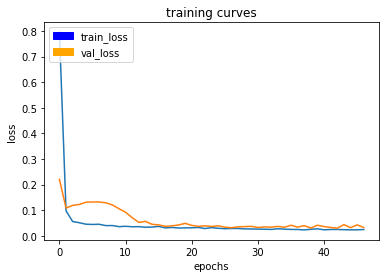

50/50 [==============================] - 109s - loss: 0.0240 - val_loss: 0.0318
Epoch 48/75
49/50 [============================>.] - ETA: 1s - loss: 0.0248

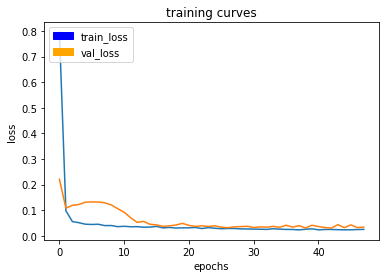

50/50 [==============================] - 110s - loss: 0.0246 - val_loss: 0.0335
Epoch 49/75
49/50 [============================>.] - ETA: 1s - loss: 0.0225

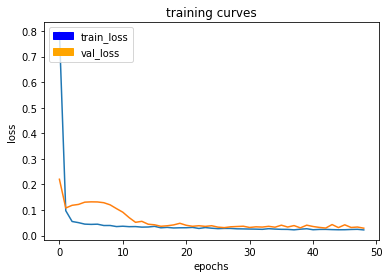

50/50 [==============================] - 109s - loss: 0.0224 - val_loss: 0.0290
Epoch 50/75
49/50 [============================>.] - ETA: 1s - loss: 0.0224

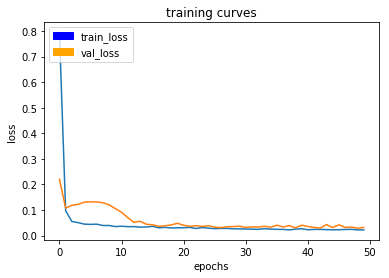

50/50 [==============================] - 110s - loss: 0.0223 - val_loss: 0.0317
Epoch 51/75
49/50 [============================>.] - ETA: 1s - loss: 0.0232

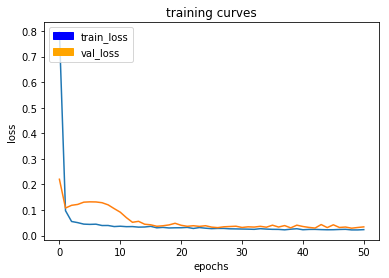

50/50 [==============================] - 111s - loss: 0.0234 - val_loss: 0.0341
Epoch 52/75
49/50 [============================>.] - ETA: 1s - loss: 0.0197

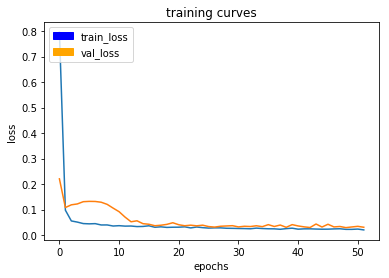

50/50 [==============================] - 110s - loss: 0.0201 - val_loss: 0.0305
Epoch 53/75
49/50 [============================>.] - ETA: 1s - loss: 0.0235

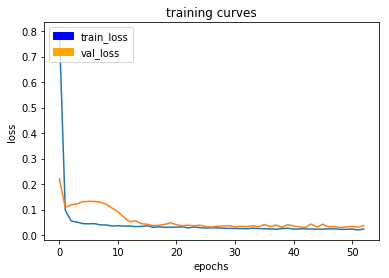

50/50 [==============================] - 110s - loss: 0.0235 - val_loss: 0.0376
Epoch 54/75
49/50 [============================>.] - ETA: 1s - loss: 0.0254

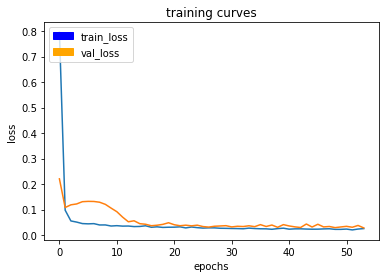

50/50 [==============================] - 110s - loss: 0.0253 - val_loss: 0.0278
Epoch 55/75
49/50 [============================>.] - ETA: 1s - loss: 0.0218

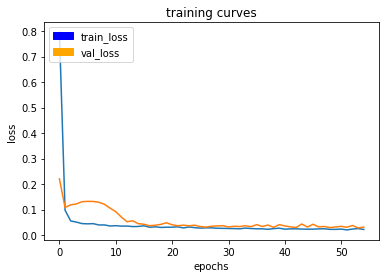

50/50 [==============================] - 110s - loss: 0.0218 - val_loss: 0.0312
Epoch 56/75
49/50 [============================>.] - ETA: 1s - loss: 0.0202

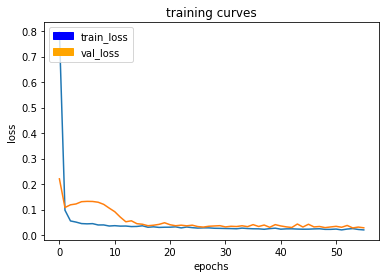

50/50 [==============================] - 110s - loss: 0.0201 - val_loss: 0.0283
Epoch 57/75
49/50 [============================>.] - ETA: 1s - loss: 0.0211

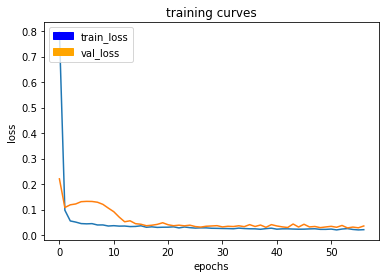

50/50 [==============================] - 110s - loss: 0.0210 - val_loss: 0.0355
Epoch 58/75
49/50 [============================>.] - ETA: 1s - loss: 0.0282

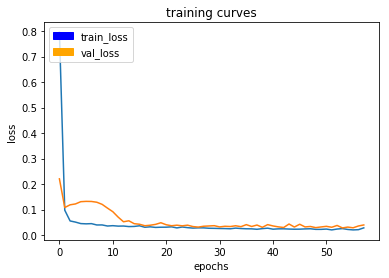

50/50 [==============================] - 111s - loss: 0.0281 - val_loss: 0.0395
Epoch 59/75
49/50 [============================>.] - ETA: 1s - loss: 0.0252

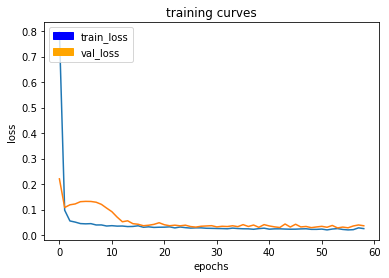

50/50 [==============================] - 110s - loss: 0.0251 - val_loss: 0.0363
Epoch 60/75
49/50 [============================>.] - ETA: 1s - loss: 0.0243

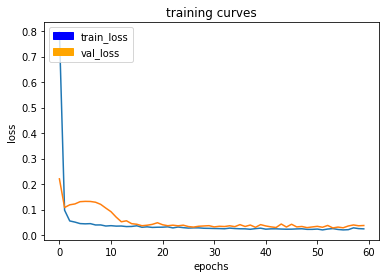

50/50 [==============================] - 111s - loss: 0.0242 - val_loss: 0.0374
Epoch 61/75
49/50 [============================>.] - ETA: 1s - loss: 0.0243

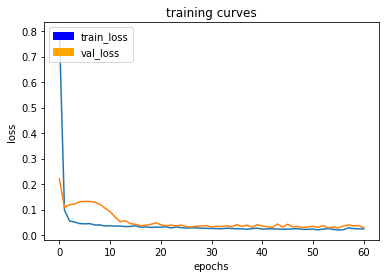

50/50 [==============================] - 110s - loss: 0.0242 - val_loss: 0.0285
Epoch 62/75
49/50 [============================>.] - ETA: 1s - loss: 0.0199

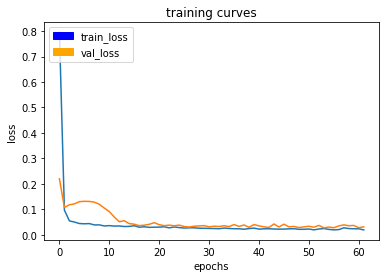

50/50 [==============================] - 110s - loss: 0.0198 - val_loss: 0.0320
Epoch 63/75
49/50 [============================>.] - ETA: 1s - loss: 0.0229

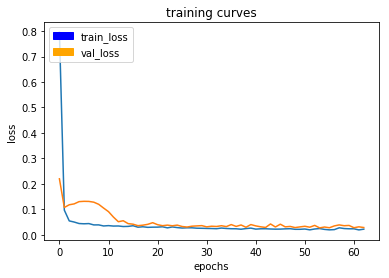

50/50 [==============================] - 109s - loss: 0.0228 - val_loss: 0.0292
Epoch 64/75
49/50 [============================>.] - ETA: 1s - loss: 0.0206

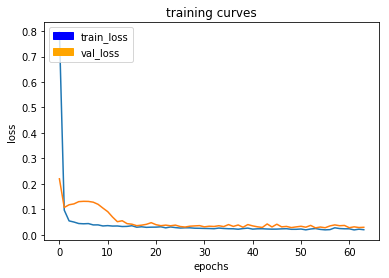

50/50 [==============================] - 111s - loss: 0.0207 - val_loss: 0.0301
Epoch 65/75
49/50 [============================>.] - ETA: 1s - loss: 0.0194

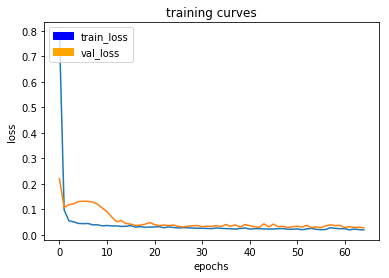

50/50 [==============================] - 110s - loss: 0.0194 - val_loss: 0.0278
Epoch 66/75
49/50 [============================>.] - ETA: 1s - loss: 0.0209

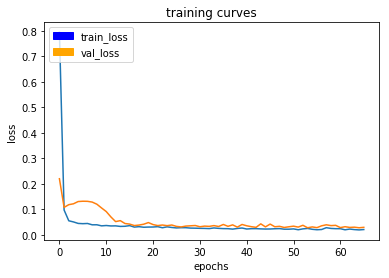

50/50 [==============================] - 111s - loss: 0.0209 - val_loss: 0.0296
Epoch 67/75
49/50 [============================>.] - ETA: 1s - loss: 0.0221

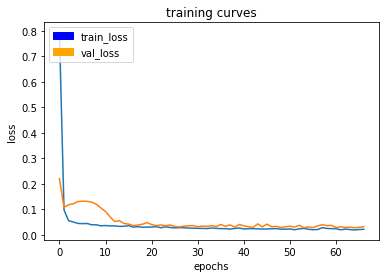

50/50 [==============================] - 110s - loss: 0.0220 - val_loss: 0.0324
Epoch 68/75
49/50 [============================>.] - ETA: 1s - loss: 0.0188

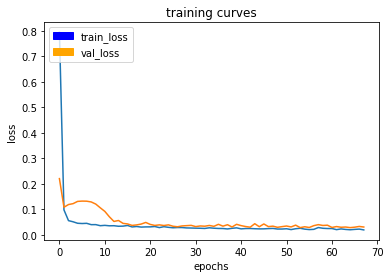

50/50 [==============================] - 110s - loss: 0.0188 - val_loss: 0.0301
Epoch 69/75
49/50 [============================>.] - ETA: 1s - loss: 0.0174

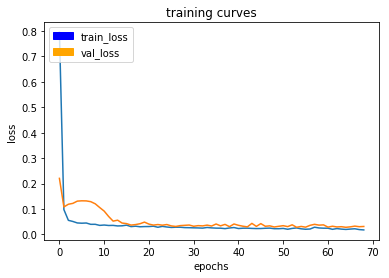

50/50 [==============================] - 107s - loss: 0.0175 - val_loss: 0.0310
Epoch 70/75
49/50 [============================>.] - ETA: 1s - loss: 0.0208

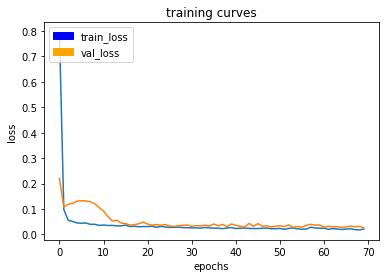

50/50 [==============================] - 110s - loss: 0.0208 - val_loss: 0.0263
Epoch 71/75
49/50 [============================>.] - ETA: 1s - loss: 0.0202

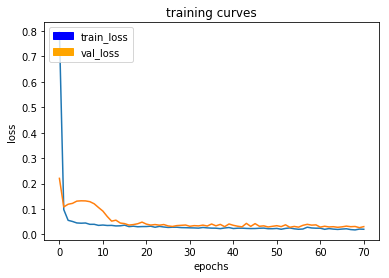

50/50 [==============================] - 108s - loss: 0.0201 - val_loss: 0.0304
Epoch 72/75
49/50 [============================>.] - ETA: 1s - loss: 0.0187

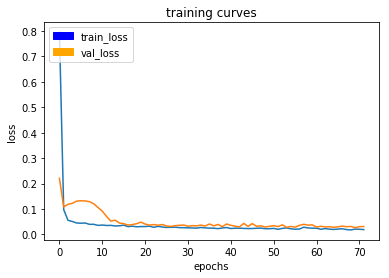

50/50 [==============================] - 110s - loss: 0.0188 - val_loss: 0.0308
Epoch 73/75
49/50 [============================>.] - ETA: 1s - loss: 0.0197

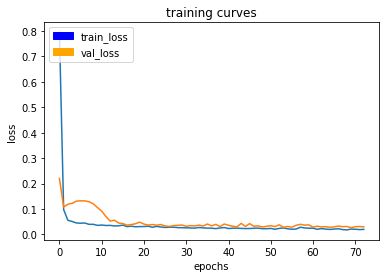

50/50 [==============================] - 112s - loss: 0.0196 - val_loss: 0.0294
Epoch 74/75
49/50 [============================>.] - ETA: 1s - loss: 0.0171

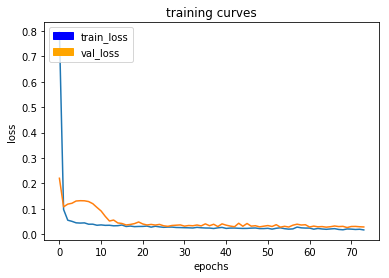

50/50 [==============================] - 110s - loss: 0.0170 - val_loss: 0.0286
Epoch 75/75
49/50 [============================>.] - ETA: 1s - loss: 0.0213

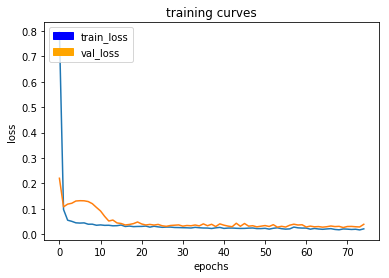

50/50 [==============================] - 110s - loss: 0.0213 - val_loss: 0.0391


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [11]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

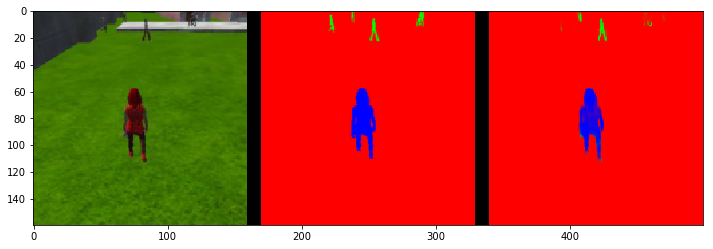

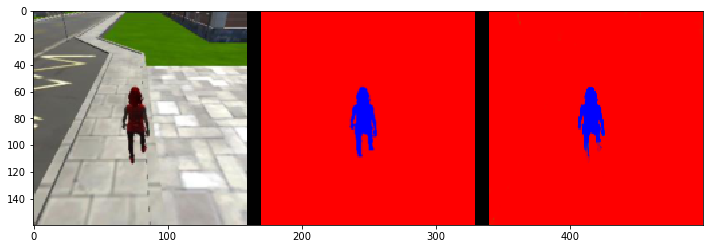

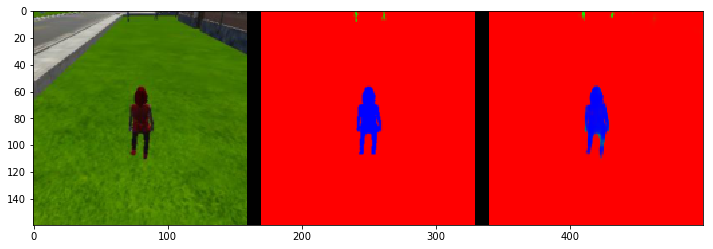

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

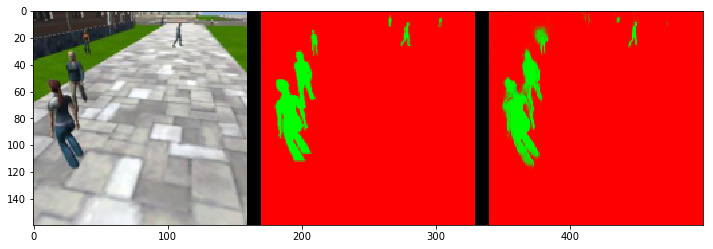

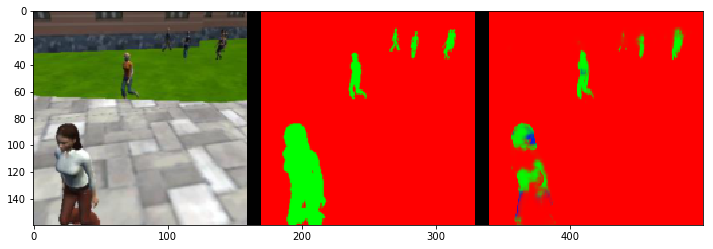

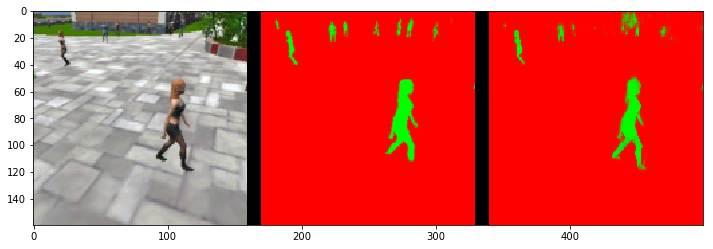

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

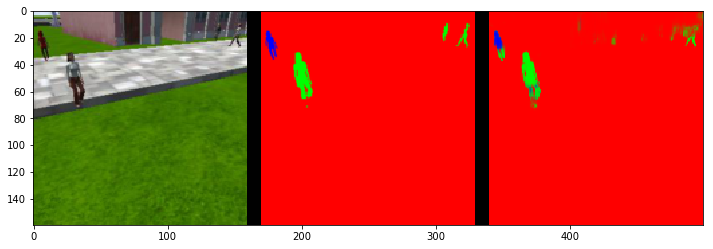

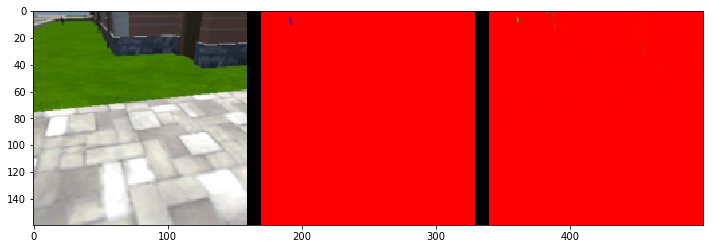

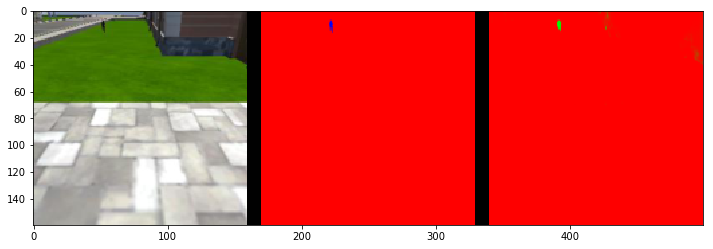

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9947366741400523
average intersection over union for other people is 0.3208827220206047
average intersection over union for the hero is 0.861394769374918
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.985028831301555
average intersection over union for other people is 0.6930375727348769
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 76, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9958295835889748
average intersection over union for other people is 0.41883578633908847
average intersection over union for the hero is 0.1864747971763001
number true positives: 128, number false positives: 1, number false negatives: 173


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7273718647764449


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.523934783276


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.381095420332
